In [1]:
import warnings
import numpy as np
import pandas as pd
warnings.filterwarnings('ignore')

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

# Algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

In [2]:
test_df = pd.read_csv("input/test.csv")
train_df = pd.read_csv("input/train.csv")

In [3]:
train_df.info()
print('-'*50)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         41

In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Combine the train and test dataset into one for processing

In [6]:
data = [train_df, test_df]

#### Embarked

In [7]:
train_df.groupby('Embarked')['Survived'].count()

Embarked
C    168
Q     77
S    644
Name: Survived, dtype: int64

In [8]:
# Fill missing value with 'S'
ports = {"S": 0, "C": 1, "Q": 2}
for dataset in data:
    dataset["Embarked"] = dataset["Embarked"].fillna("S")
    dataset['Embarked'] = dataset['Embarked'].map(ports)

#### Fare

In [9]:
for dataset in data:
    dataset['Fare'].fillna(dataset['Fare'].dropna().median(), inplace=True)
    dataset['Fare'] = dataset['Fare'].astype(int)

#### Age

Fill the missing age with random value between mean, standard deviation

In [10]:
for dataset in data:
    average_age_titanic   = dataset['Age'].mean()
    std_age_titanic       = dataset['Age'].std()
    count_nan_age_titanic = dataset['Age'].isnull().sum()
    rand_ = np.random.randint(
        average_age_titanic - std_age_titanic, 
        average_age_titanic + std_age_titanic, 
        size = count_nan_age_titanic
    )
    dataset['Age'][np.isnan(dataset['Age'])] = rand_
    dataset['Age'] = dataset['Age'].astype(int)

Convert the `Age` feature into `Age Group`

In [11]:
for dataset in data:
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6

train_df['Age'].value_counts()

6    174
4    156
5    146
3    142
2    120
1     85
0     68
Name: Age, dtype: int64

#### Name

From `Name` I create another feature call `Title`

In [12]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
                                                 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,2,1,0,A/5 21171,7,NaN,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,5,1,0,PC 17599,71,C85,1,3
2,3,1,3,"Heikkinen, Miss. Laina",female,3,0,0,STON/O2. 3101282,7,NaN,0,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,5,1,0,113803,53,C123,0,3
4,5,0,3,"Allen, Mr. William Henry",male,5,0,0,373450,8,NaN,0,1


#### Family size

In [13]:
for dataset in data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


#### IsAlone

In [14]:
for dataset in data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
train_df[['IsAlone', 'Survived']].groupby('IsAlone', as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


#### Sex

In [15]:
genders = {"male": 0, "female": 1}
for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

#### Age*Times

In [16]:
for dataset in data:
    dataset['Age_Class'] = dataset['Age']*dataset['Pclass']

#### Fare per Person

In [17]:
for dataset in data:
    dataset['FarePerPerson'] = dataset['Fare'] / dataset['FamilySize']
    dataset['FarePerPerson'] = dataset['FarePerPerson'].astype(int)

### Clean up before training the data

I decided to drop `Cabin` (many missing data) and `Ticket` (doesn't make any impacts) columns.

In [20]:
X_train = train_df.drop(['Name','Ticket', 'Cabin', 'SibSp', 'Parch', 'PassengerId', 'Survived'], axis=1)
Y_train = train_df['Survived']
X_test = test_df.drop(['Name','Ticket', 'Cabin', 'SibSp', 'Parch', 'PassengerId'], axis=1).copy()

In [22]:
X_train.head()

,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize,IsAlone,Age_Class,FarePerPerson
0,3,0,2,7,0,1,2,0,6,3
1,1,1,5,71,1,3,2,0,5,35
2,3,1,3,7,0,2,1,1,9,7
3,1,1,5,53,0,3,2,0,5,26
4,3,0,5,8,0,1,1,1,15,8


In [23]:
X_train.shape, Y_train.shape, X_test.shape

((891, 10), (891,), (418, 10))

#### Logistic Regression

In [24]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)

#### Random Forest

In [26]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_prediction = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)

#### Perceptron

In [27]:
perceptron = Perceptron(max_iter=5)
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)

#### SGDClassifier

In [29]:
sgd = SGDClassifier(max_iter=5, tol=None)
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
sgd.score(X_train, Y_train)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)

#### Decision Tree

In [31]:
decision_tree = DecisionTreeClassifier() 
decision_tree.fit(X_train, Y_train)  
Y_pred = decision_tree.predict(X_test)  
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)

#### Support Vector Machine

In [32]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)

/Users/calvin.tran/anaconda2/lib/python2.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


#### K Nearest Neighbor

In [33]:
knn = KNeighborsClassifier(n_neighbors = 3) 
knn.fit(X_train, Y_train)  
Y_pred = knn.predict(X_test)  
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)

#### Gaussian Naive Bayes

In [34]:
gaussian = GaussianNB() 
gaussian.fit(X_train, Y_train)  
Y_pred = gaussian.predict(X_test)  
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)

In [37]:
results = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 
              'Decision Tree'],
    'Score': [acc_linear_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_decision_tree]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df.head(10)

,Model
Score,
93.71,Random Forest
93.71,Decision Tree
85.07,KNN
81.26,Logistic Regression
79.46,Support Vector Machines
78.90,Naive Bayes
68.35,Perceptron
65.10,Stochastic Gradient Decent


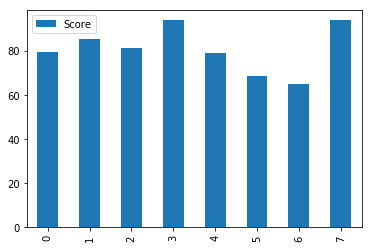

In [43]:
results.plot(kind='bar')